In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
%load_ext tensorboard

#Cargamos los datos a trabajar

x_train_pre=np.load("./data/train_signals.npy")
y_train_pre=np.load("./data/train_marks.npy")
trainLen=len(x_train_pre)

x_val_pre=np.load("./data/val_signals.npy")
y_val_pre=np.load("./data/val_marks.npy")
valLen=len(x_val_pre)

x_test_pre=np.load("./data/test_signals.npy")
y_test_pre=np.load("./data/test_marks.npy")
testLen=len(x_test_pre)

#Creamos una funcion que muestree a un ratio deseado

def sampling(signals,samples,lenght,rate):
    x_new=[]
    for i in signals:
        x=[]
        for j in range(0,lenght,rate):
            x.append(i[j])
        x_new.append(x)
    return np.array(x_new)



#Creamos una funcion que clasifique con 1 o 0 los valores de la señal a trabajar

def oneHot(marks,lenght,rate):
    y_new=[]
    for i in marks:
        y=[]
        for j in range(0,lenght,rate):
            if(i[0]<=j & j<=i[1]):
                y.append(1)
            else:
                y.append(0)
        y_new.append(y)
    return np.array(y_new)

#Obtenemos los nuevos resultados de nuestras señales a trabajar

x_train1=sampling(x_train_pre,trainLen,800,1)
x_val1=sampling(x_val_pre,valLen,800,1)
x_test1=sampling(x_test_pre,testLen,800,1)

#Obtenemos los nuevos resultados de nuestras marcas a trabajar

y_train1=oneHot(y_train_pre,800,1)
y_val1=oneHot(y_val_pre,800,1)
y_test1=oneHot(y_test_pre,800,1)


#Función que crea fragmentos de la señal original, tomando como parametros la muestra, el tamaño del fragmento deseado
#y los pasos de un fragmento a otro

def finalInputs(X,windowsSize,steps):
    newX=[]
    lenght=X.shape[1]
    for chosen in X:
        for init in range(0,lenght-windowsSize+1,steps):
            newX.append(chosen[init:init+windowsSize])
    return np.array(newX)


#Función que toma un fragmento de la salida discretizada, la promedia y la clasifica en 1 o 0 según un umbral deseado 

def finalOutputs(Y,windowsSize,steps,theshold):
    newY=[]
    lenght=Y.shape[1]
    for chosen in Y:
        for init in range(0,lenght-windowsSize+1,steps):
            total=np.mean(chosen[init:init+windowsSize])
            if(total<=theshold):
                newY.append(0)
            else:
                newY.append(1)
            
    return np.array(newY)





The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [3]:
BATCH_SIZE=20
threshold=0.5
#Se pre-procesan los datos con los valores deseados

x_trainf=finalInputs(x_train1,50,3)
y_trainf=finalOutputs(y_train1,50,3,threshold)

x_valX=finalInputs(x_val1,50,3)
y_valX=finalOutputs(y_val1,50,3,threshold)

x_valf=x_valX[0:10000]
y_valf=y_valX[0:10000]

x_testf=finalInputs(x_test1,50,3)
y_testf=finalOutputs(y_test1,50,3,threshold)



In [4]:
#Se procesas los datos para que no tenga problemas con el modelo

x_train=np.expand_dims(x_trainf,2)
y_train=tf.one_hot(y_trainf,2)


x_val=np.expand_dims(x_valf,2)
y_val=tf.one_hot(y_valf,2)

x_test=np.expand_dims(x_testf,2)
y_test=tf.one_hot(y_testf,2)

training_dataset = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(buffer_size=1024).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices(
    (x_test, y_test)).shuffle(buffer_size=1024).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (x_val, y_val)).shuffle(buffer_size=1024).batch(BATCH_SIZE)

#timexx=np.arange(0,800,1)

In [5]:
#Se crea el modelo basado en el Paper
prob=0.5
model = tf.keras.Sequential()

for i in range(0,4):
    model.add(tf.keras.layers.Conv1D(40, 7, activation='elu',padding="same"))
    model.add(tf.keras.layers.Dropout(prob))
    model.add(tf.keras.layers.MaxPool1D(pool_size=5,strides=1,padding="same"))   

model.add(tf.keras.layers.LSTM(100,dropout=0.5))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(200, activation=tf.nn.relu, name='fc1'))
model.add(tf.keras.layers.Dropout(prob))

model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax, name='fc2'))

model.build(input_shape=(None,50,1))

model.compile(loss='categorical_crossentropy',optimizer="adam",  metrics=[tf.keras.metrics.MeanIoU(num_classes=2),'accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 50, 40)            320       
_________________________________________________________________
dropout (Dropout)            (None, 50, 40)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 50, 40)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 40)            11240     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 40)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 40)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 40)            1

In [6]:
#Se crea el modelo propuesto
prob = 0.5

model2 = tf.keras.Sequential()

model2.add(tf.keras.layers.Conv1D(16, 2, activation='elu', input_shape = (50,1)))
model2.add(tf.keras.layers.MaxPool1D(pool_size=2,strides=2))

model2.add(tf.keras.layers.Conv1D(32, 2, activation='elu'))
model2.add(tf.keras.layers.Dropout(prob))
model2.add(tf.keras.layers.MaxPool1D(pool_size=2,strides=2))

model2.add(tf.keras.layers.Conv1D(48, 2, activation='elu'))
model2.add(tf.keras.layers.Dropout(prob))
model2.add(tf.keras.layers.MaxPool1D(pool_size=2,strides=2))

model2.add(tf.keras.layers.Conv1D(64, 2, activation='elu'))
model2.add(tf.keras.layers.Dropout(prob))
model2.add(tf.keras.layers.MaxPool1D(pool_size=2,strides=2))

model2.add(tf.keras.layers.LSTM(100))

model2.add(tf.keras.layers.Flatten())

model2.add(tf.keras.layers.Dense(300, activation=tf.nn.relu, name='fc2'))
model2.add(tf.keras.layers.Dropout(0.5))

model2.add(tf.keras.layers.Dense(2, name='fc3'))

model2.add(tf.keras.layers.Softmax(axis = 1))

model2.build(input_shape=(None,50,1))

model2.compile(loss='binary_crossentropy',
               optimizer="adam",
               metrics=[tf.keras.metrics.MeanIoU(num_classes=2),'accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 49, 16)            48        
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 24, 16)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 23, 32)            1056      
_________________________________________________________________
dropout_5 (Dropout)          (None, 23, 32)            0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 11, 32)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 10, 48)            3120      
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 48)           

In [7]:
model.fit(
    training_dataset, 
    epochs=10,
    steps_per_epoch=200,
    validation_data=val_dataset,
    validation_freq=1,
    callbacks=[tf.keras.callbacks.TensorBoard('./logs/model2_finaaaaaalrealx2', update_freq=100)]
)

Epoch 1/10
  1/200 [..............................] - ETA: 0s - loss: 0.4870 - mean_io_u: 0.2500 - accuracy: 0.8000WARNING:tensorflow:From C:\Users\joaqu\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
200/200 [==============================] - 13s 65ms/step - loss: 0.4787 - mean_io_u: 0.2500 - accuracy: 0.8298 - val_loss: 0.4786 - val_mean_io_u: 0.2500 - val_accuracy: 0.8362
Epoch 2/10
200/200 [==============================] - 11s 55ms/step - loss: 0.5028 - mean_io_u: 0.2500 - accuracy: 0.8100 - val_loss: 0.4416 - val_mean_io_u: 0.2500 - val_accuracy: 0.8362
Epoch 3/10
200/200 [==============================] - 11s 56ms/step - loss: 0.5110 - mean_io_u: 0.2500 - accuracy: 0.7990 - val_loss: 0.4135 - val_mean_io_u: 0.2500 - val_accuracy: 0.8362
Epoch 4/10
200/200 [==============================

In [169]:
training_dataset

<BatchDataset shapes: ((None, 50, 1), (None, 1)), types: (tf.float32, tf.int32)>

In [388]:
%tensorboard --logdir=.


Reusing TensorBoard on port 6006 (pid 8152), started 3 days, 15:18:48 ago. (Use '!kill 8152' to kill it.)

In [8]:
#Calcula las probabilidades de cada salida

def finalPredictionProba(X,model,windowsSize,steps):
    inputs=[]
    pred=[]
    lenght=len(X)
    for init in range(0,lenght-windowsSize+1,steps):
        newX=np.expand_dims(X[init:init+windowsSize],1)
        inputs.append(newX)
    inputs=np.array(inputs)
    output=model.predict(inputs)
    return output

#Clasifica las probabilidades según un umbral
def predictionOnes(Y,threshold):
    ans=[]
    for i in Y:
        if(i[1]>=threshold):
            ans.append(1)
        else:
            ans.append(0)
    return ans


####
####
####
#### ESTA FUNCIÓN TIRA UN ERROR A VECES
####
####
####

#Calcula el rango de las salidas predichas
def rangeOnes(y):
    ones=[]
    lenght=len(y)
    for i in range(0,lenght):
        if(y[i]==1):
            ones.append(i)
    rang=[ones[0],ones[len(ones)-1]]
    return np.array(rang)

#Corrige el rango al tamaño original de la señal de entrada
def originalSize(rangeOf,Osize,Fsize):
    prop=Osize/Fsize
    ans=[]
    first=np.int(prop*rangeOf[0])
    second=np.int(prop*rangeOf[1])
    return np.array([first,second])     

#Entrega el rango predicho final, uniendo todas las funciones anteriores
def finalPrediction(X,model,windowsSize,steps,threshold):
    lenX=len(X)
    predictionProba=finalPredictionProba(X,model,windowsSize,steps)
    lenPred=len(predictionProba)
    predictOnes=predictionOnes(predictionProba,threshold)
    rangOnes=rangeOnes(predictOnes)
    predictFinal=originalSize(rangOnes,lenX,lenPred)
    return predictFinal

#Entrega la salida predicha discretizada
def realOutput(rangeOf,size):
    output=[]
    for i in range(0,size):
        if(rangeOf[0]<=i and i<=rangeOf[1]):
            output.append(1)
        else:
            output.append(0)
    return output
    

In [9]:
#Calcula el IoU de una predicción
def IOU(x,y,model,windowsSize,steps,threshold):
    prediction=finalPrediction(x,model,windowsSize,steps,threshold)
    real=rangeOnes(y)
    union=max(prediction[1],real[1])-min(prediction[0],real[0])
    overlap=min(prediction[1],real[1])-max(prediction[0],real[0])
    return overlap/union

#Calcula el IoU de un grupo de predicciónes
def allIOUfunct(x,y,model,windowsSize,steps,threshold,clases):
    allIOU=[]
    lenght=len(y)
    for i in range(0,lenght):
        iou=IOU(x[i],y[i],model,windowsSize,steps,threshold)
        allIOU.append(iou)
        
    plt.figure(figsize=(20,10))
    plt.hist(allIOU,clases,color="blue",ec="black")
    plt.title('IoU',fontsize=15)
    plt.ylabel('Cantidad de sucesos',fontsize=15)
    plt.xlabel('Tiempo',fontsize=15)
    

In [16]:
#Prepara para plotear los x
def areaX(rangeOf):
    area=[]
    first=np.int(np.round((rangeOf[0])))
    second=np.int(np.round(rangeOf[1]))
    for i in range(first,second):
        area.append(i)
    return np.array(area)

#Prepara para plotear los y
def areaY(rangeOf,size):
    area=[0]
    l=np.int(rangeOf[1]-rangeOf[0])
    for i in range(1,l-1):
        area.append(size)
    area.append(0)
    return np.array(area)

#Grafica la señal, la area real donde hay un huso, y el area donde predice que ocurre
def graphFinal(x,y,model,windowsSize,steps,threshold):
    predict=finalPrediction(x,model,windowsSize,steps,threshold)

    predAreaX=areaX(predict)
    predAreaY=areaY(predict,60)
    
    realRange=rangeOnes(y)
    realAreaX=areaX(realRange)
    realAreaY=areaY(realRange,60)
    
    plt.figure(figsize=(20,10))
    plt.plot(x,'b')
    plt.plot(realAreaX,realAreaY,'g',label='Area Real')
    plt.plot(realAreaX,-1*realAreaY,'g')
    
    plt.plot(predAreaX,predAreaY,'r',label='Area Predicha')
    plt.plot(predAreaX,-1*predAreaY,'r')
    
    plt.title('Localización del Huso Sigma',fontsize=15)
    plt.ylabel('Amplitud',fontsize=15)
    plt.xlabel('Tiempo',fontsize=15)
    plt.legend(loc="upper right",fontsize=15)
    plt.tick_params(labelsize=15)
graphFinal(x_test1[10],y_test1[10],model,50,3,0.07)

IndexError: list index out of range

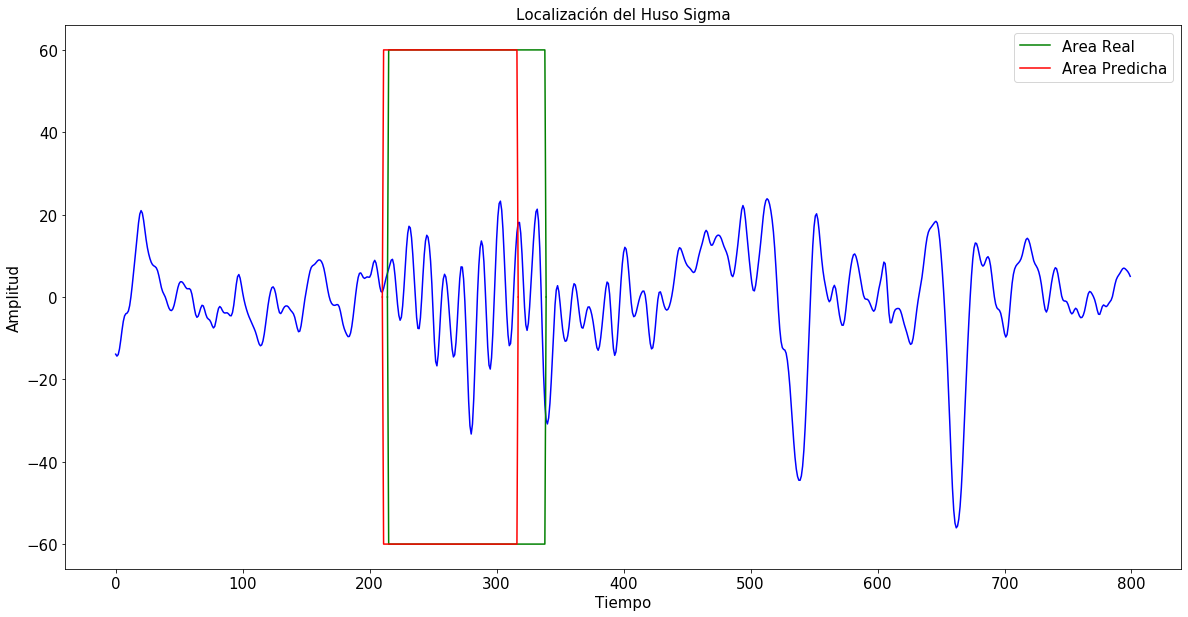

In [419]:
graphFinal(x_val1[1],y_val1[1],model,50,3,0.05)

In [418]:
finalPredictionProba(x_test1[0],model,50,3)

array([[0.98977697, 0.01022303],
       [0.9928536 , 0.00714648],
       [0.9923844 , 0.00761566],
       [0.99109733, 0.00890273],
       [0.99093634, 0.0090637 ],
       [0.99205595, 0.00794402],
       [0.9934348 , 0.00656528],
       [0.9937302 , 0.00626978],
       [0.9946419 , 0.00535808],
       [0.993046  , 0.00695404],
       [0.98966414, 0.01033592],
       [0.9915181 , 0.00848191],
       [0.9929721 , 0.0070279 ],
       [0.9937168 , 0.00628325],
       [0.9933374 , 0.00666265],
       [0.9925874 , 0.00741267],
       [0.9913203 , 0.00867974],
       [0.99211895, 0.00788105],
       [0.99290025, 0.00709977],
       [0.9937442 , 0.00625579],
       [0.99377394, 0.00622603],
       [0.99341375, 0.00658623],
       [0.9934009 , 0.00659911],
       [0.99210876, 0.00789128],
       [0.9895176 , 0.01048233],
       [0.9920398 , 0.00796022],
       [0.99240077, 0.00759916],
       [0.9919172 , 0.00808283],
       [0.9912042 , 0.00879575],
       [0.99200857, 0.00799147],
       [0.

In [17]:
x_val1XXX=x_val1[0:60]
y_val1XXX=y_val1[0:60]
allIOUfunct(x_val1XXX,y_val1XXX,model,50,3,0.05,10)

IndexError: list index out of range

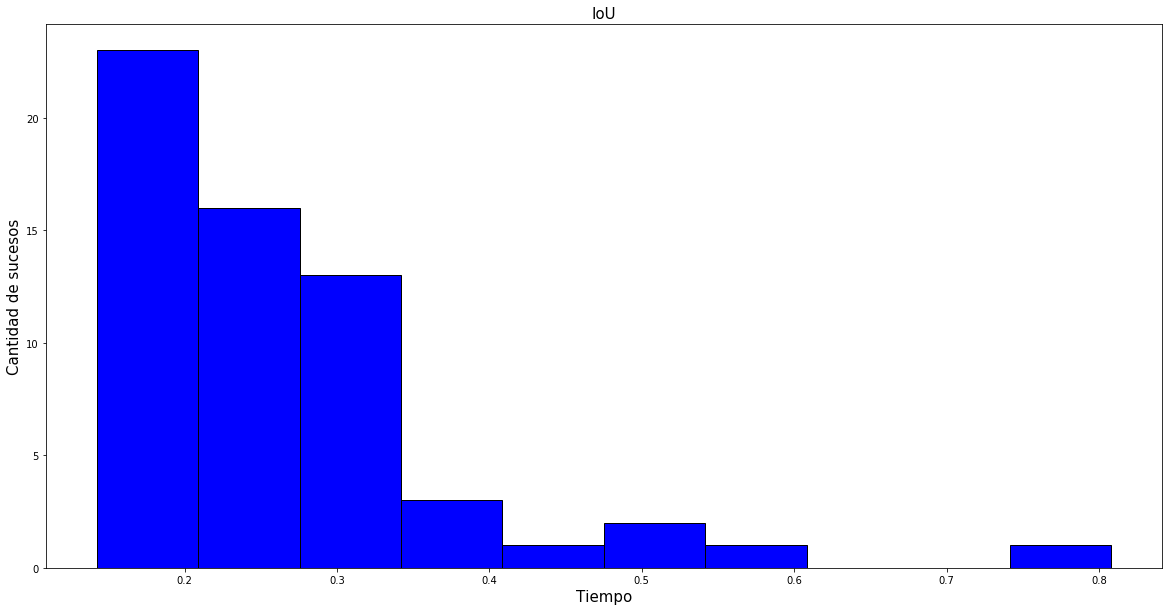

In [430]:
allIOUfunct(x_val1XXX,y_val1XXX,model,50,3,0.01,10)